In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

In [2]:
@numba.jit(nopython=True)
# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth_cross(J,H,state,meth_state,m0,delta_fm,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to methylation-independent external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = -0.5*delta_fm*(meth_state-m0)*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

@numba.jit(nopython=True)
# function that finds the (de)methylation rates 
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [3]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,L):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(L**2))].reshape((L,L))

@numba.jit(nopython=True)
# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,m0=0.5,delta_fm=-2):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation with a biase
        dt = 0
        time = 0
        spin_state = biased_choice(np.array([-1.,1.]),np.array([2/3,1/3]),L)
        meth_state = biased_choice(np.arange(0,5),np.array([0.4,0.3,0.1,0.1,0.1]),L)
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*np.log((1 + c/Ki)/(1 + c/Ka))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state,m0,delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state,m0,delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
        
    #################
    ### Averaging ###
    #################
    
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((2,n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                for k in range(2):
                    ensemble_av[k,step,spin1,spin2] = np.mean(all_states[k,:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [7]:
# function for computing power spectrum
def power_spectrum(time, data):
    # extract info about the sampling
    n_points = data.size
    tf = time[-1]
    sr = n_points/tf
    
    # remove DC and normalise data by sample size
    signal = (data-np.mean(data))/n_points
    
    # compute power spectrum
    ps = np.abs(np.fft.fft(signal))**2
    
    # extract frequencies
    # note: dt = 1/sr and multiply by sr for units
    freqs = np.fft.fftfreq(signal.size,1/sr)*sr
    
    # signal is real, so only extract positive frequencies
    pos_freqs = freqs[freqs >= 0]
    
    # sort
    idx_sorted = np.argsort(pos_freqs)
    
    return pos_freqs[idx_sorted], ps[idx_sorted]

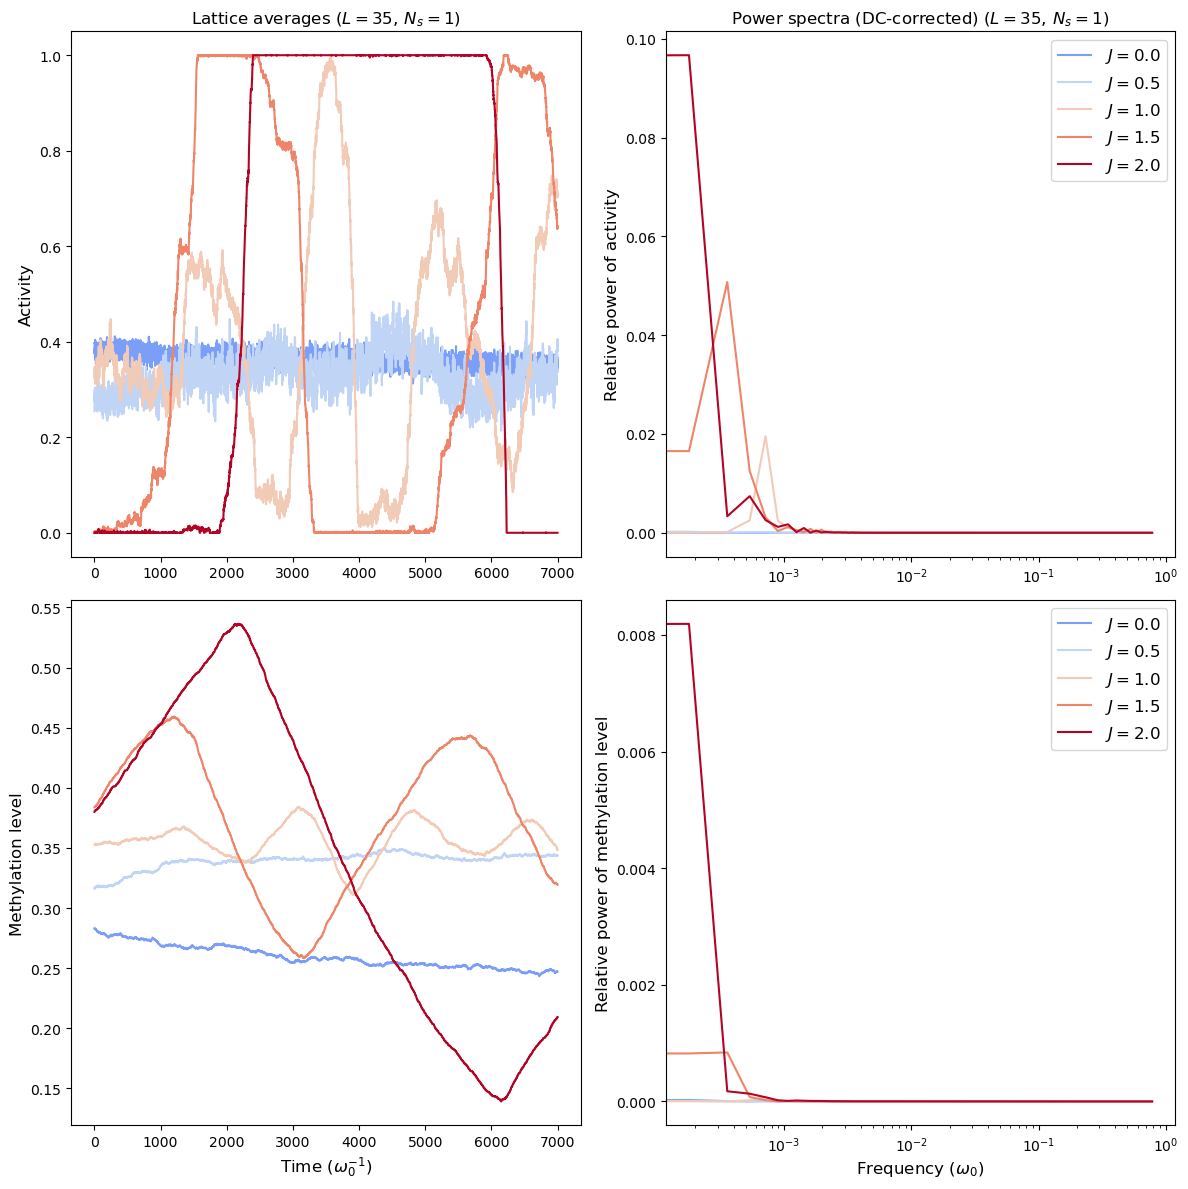

In [128]:
# parameters
n_samples = 1
n_steps = 10000
tf = 8000
co = 1250
L = 35
omega0 = 40.
kR = 0.015/omega0
kB = 2*kR

J_arr = np.linspace(0.,2.,5)

# figure prep
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# arrays to store results
max_freqs = np.zeros((2,J_arr.size))
max_powers = np.zeros_like(max_freqs)

for i,J in enumerate(J_arr):
    # extract activity, methylation and cut off transient
    all_states, _, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB)
    act = 0.5*np.mean(all_states[0,0,co:,:,:], axis=(1,2)) + 0.5
    meth = np.mean(all_states[1,0,co:,:,:], axis=(1,2))
    
    t_shifted = t_grid[co:] - t_grid[co]
    
    # show results
    ax1.plot(t_shifted,act,label=f'$J={np.round(J,2)}$',color=colormap((i+1)/J_arr.size))
    
    # obtain frequencies and power spectrum
    freqs, ps = power_spectrum(t_shifted, act)
    
    # show results
    ax2.semilogx(freqs,ps,label=f'$J={np.round(J,2)}$',color=colormap((i+1)/J_arr.size))
    
    # extract most dominant frequency and corresponding power
    max_freqs[0,i] = freqs[np.argmax(ps)]
    max_powers[0,i] = np.max(ps)
    
    # do the same for the methylation level
    ax3.plot(t_shifted,meth,label=f'$J={np.round(J,2)}$',color=colormap((i+1)/J_arr.size))
    
    # obtain frequencies and power spectrum
    freqs, ps = power_spectrum(t_shifted, meth)
    
    # show results
    ax4.semilogx(freqs,ps,label=f'$J={np.round(J,2)}$',color=colormap((i+1)/J_arr.size))
    
    # extract most dominant frequency and corresponding power
    max_freqs[1,i] = freqs[np.argmax(ps)]
    max_powers[1,i] = np.max(ps)
    
# figure formatting
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Lattice averages $(L={L},\, N_s={n_samples})$')

ax2.set_ylabel('Relative power of activity',size=12)
#ax2.set_xlim(0,0.005)
ax2.set_title(f'Power spectra (DC-corrected) $(L={L},\, N_s={n_samples})$')
ax2.legend(fontsize=12)

# figure formatting
ax3.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax3.set_ylabel('Methylation level',size=12)

ax4.set_xlabel(r'Frequency $(\omega_0)$',size=12)
ax4.set_ylabel('Relative power of methylation level',size=12)
#ax4.set_xlim(0,0.005)
ax4.legend(fontsize=12)

plt.tight_layout()

plt.show()

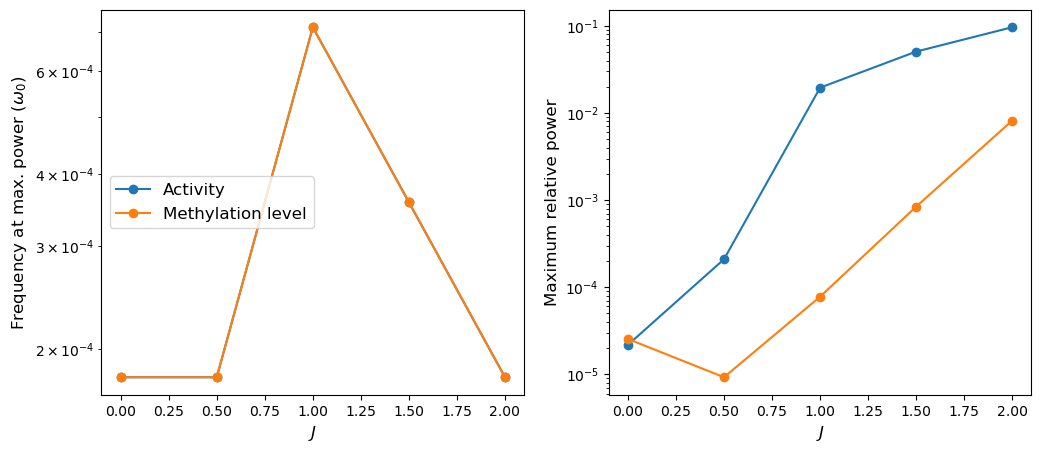

In [130]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.semilogy(J_arr, max_freqs[0,:],'-o',label='Activity')
ax1.plot(J_arr, max_freqs[1,:],'-o',label='Methylation level')
ax1.set_xlabel(f'$J$',size=12)
ax1.set_ylabel(r'Frequency at max. power ($\omega_0)$',size=12)
ax1.legend(fontsize=12)

ax2.semilogy(J_arr, max_powers[0,:],'-o',label='Activity')
ax2.plot(J_arr, max_powers[1,:],'-o',label='Methylation level')
ax2.set_xlabel(f'$J$',size=12)
ax2.set_ylabel('Maximum relative power',size=12)

plt.show()

This provides strong evidence that for strong enough coupling, any oscillations in the average activity of the lattice are tightly coupled to oscillations in the average methylation level! 